### Import packages

In [1]:
import os
import copy

import torch
from tqdm import tqdm
import torchvision
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torchvision.transforms import v2 as transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn


from pytorch_adapt.containers import Models, Optimizers
from pytorch_adapt.datasets import (
    DataloaderCreator,
    SourceDataset,
    TargetDataset,
    CombinedSourceAndTargetDataset,
    ConcatDataset,
)
from pytorch_adapt.hooks import (
    ATDOCHook,
    BNMHook,
    DANNHook,
    MCDHook,
    MCCHook,
    AlignerPlusCHook,
    ClassifierHook,
    FinetunerHook,
)
from pytorch_adapt.layers import MCCLoss, MMDLoss, MultipleModels
from pytorch_adapt.models import Discriminator
from pytorch_adapt.utils.common_functions import batch_to_device
from pytorch_adapt.validators import AccuracyValidator
from pytorch_adapt.weighters import MeanWeighter
from pytorch_adapt.layers.utils import get_kernel_scales
from pytorch_adapt.utils import common_functions as c_f

from common.CustomData.MRI_NII_2D import Dataset2D
from common.networks import get_auto_transform, get_feature_extractor, Classifier
from common.utils import (
    print_train_time,
    EarlyStoppingMinimizeLoss,
    ModelCheckpointBestAcc,
    create_directory,
)

In [2]:
def imshow(inp, size=(5, 5), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Identity()

G = model.to("cpu")

In [ ]:
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

### Create datasets and dataloaders

In [3]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
transform_net = get_auto_transform("resnet50")

In [6]:
transform_net

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
class GrayscaleToRGB:
    def __call__(self, x):
        if x.size(0) == 3:
            return x
        elif x.size(0) == 1:
            return torch.cat([x, x, x], dim=0)
        else:
            raise Exception("Image is not grayscale (or even RGB).")

In [8]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToImage(),
            transforms.Resize(232),
            transforms.CenterCrop(224),
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            GrayscaleToRGB(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val_test": transforms.Compose(
        [
            transforms.ToImage(),
            transforms.Resize(232),
            transforms.CenterCrop(224),
            GrayscaleToRGB(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [9]:
src_train = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="GE",
    split="train",
    transform=data_transforms["val_test"],
)
src_train_transform = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="GE",
    split="train",
    transform=data_transforms["train"],
)
src_val = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="GE",
    split="val",
    transform=data_transforms["val_test"],
)

src_val_transform = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="GE",
    split="val",
    transform=data_transforms["train"],
)
src_test = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="GE",
    split="test",
    transform=data_transforms["val_test"],
)

2024-11-27 17:43:38.689 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - +++++++++++++++Loading Image and Label data from MRI 2D+++++++++++++++
2024-11-27 17:43:38.743 | INFO     | common.CustomData.MRI_NII_2D:__init__:23 - ++++++++++++++++++++++++++Loading Label Data++++++++++++++++++++++++++
2024-11-27 17:43:38.744 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - +++++++++++++++Loading Image and Label data from MRI 2D+++++++++++++++
2024-11-27 17:43:38.780 | INFO     | common.CustomData.MRI_NII_2D:__init__:23 - ++++++++++++++++++++++++++Loading Label Data++++++++++++++++++++++++++
2024-11-27 17:43:38.781 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - +++++++++++++++Loading Image and Label data from MRI 2D+++++++++++++++
2024-11-27 17:43:38.786 | INFO     | common.CustomData.MRI_NII_2D:__init__:23 - ++++++++++++++++++++++++++Loading Label Data++++++++++++++++++++++++++
2024-11-27 17:43:38.787 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - ++++++++++++++

In [10]:
target_train = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="Philips",
    split="train",
    transform=data_transforms["val_test"],
)

target_train_transform = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="Philips",
    split="train",
    transform=data_transforms["train"],
)
target_val = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="Philips",
    split="val",
    transform=data_transforms["val_test"],
)
target_test = Dataset2D(
    root=r"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\data\ADNI1-T1-AD-CN\Image\Preprocess\6_step_nifti_2d",
    domain="Philips",
    split="test",
    transform=data_transforms["val_test"],
)

2024-11-27 17:43:38.807 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - +++++++++++++++Loading Image and Label data from MRI 2D+++++++++++++++
2024-11-27 17:43:38.823 | INFO     | common.CustomData.MRI_NII_2D:__init__:23 - ++++++++++++++++++++++++++Loading Label Data++++++++++++++++++++++++++
2024-11-27 17:43:38.824 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - +++++++++++++++Loading Image and Label data from MRI 2D+++++++++++++++
2024-11-27 17:43:38.839 | INFO     | common.CustomData.MRI_NII_2D:__init__:23 - ++++++++++++++++++++++++++Loading Label Data++++++++++++++++++++++++++
2024-11-27 17:43:38.841 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - +++++++++++++++Loading Image and Label data from MRI 2D+++++++++++++++
2024-11-27 17:43:38.844 | INFO     | common.CustomData.MRI_NII_2D:__init__:23 - ++++++++++++++++++++++++++Loading Label Data++++++++++++++++++++++++++
2024-11-27 17:43:38.845 | INFO     | common.CustomData.MRI_NII_2D:__init__:19 - ++++++++++++++

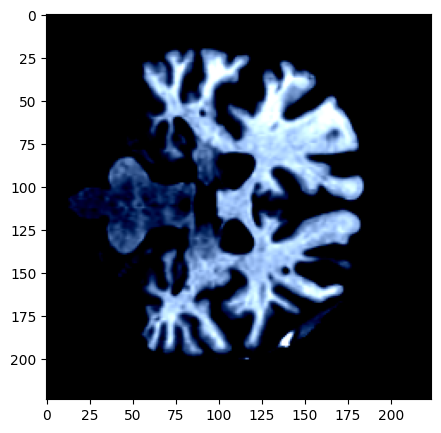

In [11]:
# Get a batch of training data
inputs, classes = next(iter(src_train_transform))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(inputs)

In [12]:
inputs.shape

torch.Size([3, 224, 224])

In [13]:
algorithm = "A"

In [14]:
dataset = {}

dataset["src_train"] = SourceDataset(ConcatDataset([src_train, src_val]))
dataset["src_val"] = SourceDataset(src_test)

dataset["target_train"] = TargetDataset(target_train)
dataset["target_val"] = TargetDataset(target_val)
dataset["target_test"] = TargetDataset(target_test)

dataset["target_train_with_labels"] = TargetDataset(
    target_train, domain=1, supervised=True
)
dataset["target_val_with_labels"] = TargetDataset(target_val, domain=1, supervised=True)
dataset["target_test_with_labels"] = TargetDataset(
    target_test, domain=1, supervised=True
)

dataset["train"] = CombinedSourceAndTargetDataset(
    SourceDataset(ConcatDataset([src_train_transform, src_val_transform])),
    TargetDataset(target_train_transform),
)

# Create datasets and dataloaders
if algorithm == "source-only":
    train_names, val_names = ["src_train"], [
        "train",
        "src_val",
        "target_train",
        "target_train_with_labels",
        "target_val",
        "target_val_with_labels",
        "target_test",
        "target_test_with_labels",
    ]
else:
    train_names, val_names = ["train"], [
        "src_train",
        "src_val",
        "target_train",
        "target_train_with_labels",
        "target_val",
        "target_val_with_labels",
        "target_test",
        "target_test_with_labels",
    ]

In [15]:
dc = DataloaderCreator(
    batch_size=64, num_workers=0, train_names=train_names, val_names=val_names
)

In [16]:
dataloaders = dc(**dataset)

In [17]:
target_dataset_size = len(dataset["target_train"])

### Model

## Testes

In [18]:
VALIDATORS = {
    "src_train_acc_score": lambda kwargs: (
        AccuracyValidator(),
        {"src_val": "src_train"},
    ),
    "src_val_acc_score": lambda kwargs: (AccuracyValidator(), {"src_val": "src_val"}),
    "target_train_acc_score": lambda kwargs: (
        AccuracyValidator(),
        {"src_val": "target_train"},
    ),
    "target_val_acc_score": lambda kwargs: (
        AccuracyValidator(),
        {"src_val": "target_val"},
    ),
    "target_test_acc_score": lambda kwargs: (
        AccuracyValidator(),
        {"src_val": "target_test"},
    ),
}

In [19]:
chosen_validators = {
    key: VALIDATORS[key]({"num_classes": 2})
    for key in [
        "src_train_acc_score",
        "src_val_acc_score",
        "target_train_acc_score",
        "target_val_acc_score",
        "target_test_acc_score",
    ]
}

In [20]:
chosen_validators

{'src_train_acc_score': (AccuracyValidator(required_data=['src_val']),
  {'src_val': 'src_train'}),
 'src_val_acc_score': (AccuracyValidator(required_data=['src_val']),
  {'src_val': 'src_val'}),
 'target_train_acc_score': (AccuracyValidator(required_data=['src_val']),
  {'src_val': 'target_train'}),
 'target_val_acc_score': (AccuracyValidator(required_data=['src_val']),
  {'src_val': 'target_val'}),
 'target_test_acc_score': (AccuracyValidator(required_data=['src_val']),
  {'src_val': 'target_test'})}

In [21]:
splits = list(
    set([val for v in chosen_validators for val in chosen_validators[v][1].values()])
)
split_splits = [key.split("_") for key in splits]
splits_with_labels = []
for split in split_splits:
    s = f"{split[1]}_with_labels" if split[0] == "target" else split[1]
    splits_with_labels.append([split[0], s])

eval_data = {a: b for a, b in zip(*(splits, splits_with_labels))}
eval_data

{'src_train': ['src', 'train'],
 'src_val': ['src', 'val'],
 'target_test': ['target', 'test_with_labels'],
 'target_val': ['target', 'val_with_labels'],
 'target_train': ['target', 'train_with_labels']}

In [22]:
d = {"epoch": 1}
data = {
    "target_val": {"labels": 9, "fl0": 9, "fl3": 9, "fl6": 9, "logits": 9, "preds": 9},
    "target_train": {
        "labels": 9,
        "fl0": 9,
        "fl3": 9,
        "fl6": 9,
        "logits": 9,
        "preds": 9,
    },
    "src_train": {"labels": 9, "fl0": 9, "fl3": 9, "fl6": 9, "logits": 9, "preds": 9},
    "target_test": {"labels": 9, "fl0": 9, "fl3": 9, "fl6": 9, "logits": 9, "preds": 9},
    "src_val": {"labels": 9, "fl0": 9, "fl3": 9, "fl6": 9, "logits": 9, "preds": 9},
}
for name, (validator, input_keys) in chosen_validators.items():
    print("----------------------")
    print(name)
    print(validator)
    d[name] = {key: data[value] for key, value in input_keys.items()}
    print(d[name])

----------------------
src_train_acc_score
AccuracyValidator(required_data=['src_val'])
{'src_val': {'labels': 9, 'fl0': 9, 'fl3': 9, 'fl6': 9, 'logits': 9, 'preds': 9}}
----------------------
src_val_acc_score
AccuracyValidator(required_data=['src_val'])
{'src_val': {'labels': 9, 'fl0': 9, 'fl3': 9, 'fl6': 9, 'logits': 9, 'preds': 9}}
----------------------
target_train_acc_score
AccuracyValidator(required_data=['src_val'])
{'src_val': {'labels': 9, 'fl0': 9, 'fl3': 9, 'fl6': 9, 'logits': 9, 'preds': 9}}
----------------------
target_val_acc_score
AccuracyValidator(required_data=['src_val'])
{'src_val': {'labels': 9, 'fl0': 9, 'fl3': 9, 'fl6': 9, 'logits': 9, 'preds': 9}}
----------------------
target_test_acc_score
AccuracyValidator(required_data=['src_val'])
{'src_val': {'labels': 9, 'fl0': 9, 'fl3': 9, 'fl6': 9, 'logits': 9, 'preds': 9}}


In [23]:
{"src_val": {"labels": 9, "fl0": 9, "fl3": 9, "fl6": 9, "logits": 9, "preds": 9}}

{'src_val': {'labels': 9,
  'fl0': 9,
  'fl3': 9,
  'fl6': 9,
  'logits': 9,
  'preds': 9}}

## Train

In [24]:
# ['source-only', 'atdoc', 'bnm', 'dann', 'mcc', 'mcd', 'mmd']

In [25]:
device = torch.device("cuda")

kernel_scales = get_kernel_scales(low=-3, high=3, num_kernels=10)
loss_fn = MMDLoss(kernel_scales=kernel_scales)

for alg_class in ["source-only", "atdoc", "bnm", "dann", "mcc", "mcd", "mmd"]:
    # Create datasets and dataloaders
    if alg_class == "source-only":
        train_names, val_names = ["src_train"], [
            "train",
            "src_val",
            "target_train",
            "target_train_with_labels",
            "target_val",
            "target_val_with_labels",
            "target_test",
            "target_test_with_labels",
        ]
    else:
        train_names, val_names = ["train"], [
            "src_train",
            "src_val",
            "target_train",
            "target_train_with_labels",
            "target_val",
            "target_val_with_labels",
            "target_test",
            "target_test_with_labels",
        ]

    dataloaders = dc(**dataset)

    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Identity()

    G = model.to(device)
    C = Classifier(2, 512, 256)
    if alg_class == "mcd":
        C = MultipleModels(C, c_f.reinit(copy.deepcopy(C))).to(device)
    else:
        C = C.to(device)
    D = Discriminator(in_size=512).to(device)
    models = Models({"G": G, "C": C, "D": D})
    optimizers = Optimizers(
        (torch.optim.Adam, {"lr": 0.001}), multipliers={"G": 1.0, "C": 1.0, "D": 1.0}
    )
    optimizers.create_with(models)
    optimizers = list(optimizers.values())

    HOOKS = {
        "source-only": FinetunerHook(opts=[optimizers[1]]),
        "atdoc": ClassifierHook(
            opts=[optimizers[0], optimizers[1]],
            post=[
                ATDOCHook(
                    dataset_size=target_dataset_size, feature_dim=512, num_classes=2
                )
            ],
        ),
        "bnm": ClassifierHook(opts=[optimizers[0], optimizers[1]], post=[BNMHook()]),
        "dann": DANNHook(opts=optimizers[:3]),
        "mcc": ClassifierHook(
            opts=[optimizers[0], optimizers[1]],
            post=[MCCHook(loss_fn=MCCLoss())],
        ),
        "mcd": MCDHook(g_opts=[optimizers[0]], c_opts=[optimizers[1]]),
        "mmd": AlignerPlusCHook(
            opts=[optimizers[0], optimizers[1]], loss_fn=loss_fn, softmax=True
        ),
    }

    alg_name = alg_class
    validator_name = "accVal"
    hook = HOOKS[alg_name]

    validator = AccuracyValidator()

    model_checkpoint = ModelCheckpointBestAcc(
        name=f"{alg_name}.pt",
        path_save=os.path.join("models"),
    )

    for epoch in range(25):

        # train loop
        print(f"Epoch {epoch}")
        print("Train")
        models.train()
        for data in tqdm(dataloaders["train"]):
            data = batch_to_device(data, device)
            _, loss = hook({**models, **data})

        # eval loop
        print("Eval")
        models.eval()
        labels, logits, preds = [], [], []
        with torch.no_grad():
            for data in tqdm(dataloaders["target_val_with_labels"]):
                data = batch_to_device(data, device)
                logit = C(G(data["target_imgs"]))
                if isinstance(logit, list):
                    logit = logit[0]
                pred = F.softmax(logit, dim=-1)
                logits.append(logit)
                preds.append(pred)
                if f"target_labels" in data:
                    label = data[f"target_labels"]
                    labels.append(label)

        logits = torch.cat(logits, dim=0)
        preds = torch.cat(preds, dim=0)
        if labels:
            labels = torch.cat(labels, dim=0)
        # validation score
        score = validator(src_val={"logits": logits, "preds": preds, "labels": labels})
        model_checkpoint(models, score)
        print(f"\nEpoch {epoch} score = {score*100}\n")

Epoch 0
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.65it/s]
2024-11-20 19:04:47.468 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 51.1905



Epoch 0 score = 51.1904776096344

Epoch 1
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.83it/s]
2024-11-20 19:05:10.914 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 52.5298



Epoch 1 score = 52.52976417541504

Epoch 2
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.86it/s]



Epoch 2 score = 50.89285969734192

Epoch 3
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.89it/s]
2024-11-20 19:05:57.099 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 52.8274



Epoch 3 score = 52.82738208770752

Epoch 4
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.56it/s]
2024-11-20 19:06:20.290 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 54.1667



Epoch 4 score = 54.16666865348816

Epoch 5
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.86it/s]
2024-11-20 19:06:43.413 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 55.0595



Epoch 5 score = 55.0595223903656

Epoch 6
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]



Epoch 6 score = 53.57142686843872

Epoch 7
Train


100%|██████████| 57/57 [00:21<00:00,  2.65it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.85it/s]



Epoch 7 score = 54.16666865348816

Epoch 8
Train


100%|██████████| 57/57 [00:21<00:00,  2.60it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.29it/s]



Epoch 8 score = 54.46428656578064

Epoch 9
Train


100%|██████████| 57/57 [00:22<00:00,  2.51it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.87it/s]
2024-11-20 19:08:17.895 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 55.5060



Epoch 9 score = 55.5059552192688

Epoch 10
Train


100%|██████████| 57/57 [00:24<00:00,  2.33it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.21it/s]



Epoch 10 score = 55.20833134651184

Epoch 11
Train


100%|██████████| 57/57 [00:23<00:00,  2.46it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.76it/s]



Epoch 11 score = 54.76190447807312

Epoch 12
Train


100%|██████████| 57/57 [00:22<00:00,  2.49it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.19it/s]



Epoch 12 score = 55.0595223903656

Epoch 13
Train


100%|██████████| 57/57 [00:22<00:00,  2.59it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.46it/s]
2024-11-20 19:09:57.806 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 55.6548



Epoch 13 score = 55.65476417541504

Epoch 14
Train


100%|██████████| 57/57 [00:22<00:00,  2.54it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.06it/s]
2024-11-20 19:10:21.899 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 56.1012



Epoch 14 score = 56.10119104385376

Epoch 15
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.10it/s]
2024-11-20 19:10:45.373 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 56.2500



Epoch 15 score = 56.25

Epoch 16
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.16it/s]



Epoch 16 score = 55.95238208770752

Epoch 17
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.98it/s]



Epoch 17 score = 55.5059552192688

Epoch 18
Train


100%|██████████| 57/57 [00:21<00:00,  2.60it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 18 score = 55.65476417541504

Epoch 19
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.91it/s]



Epoch 19 score = 55.65476417541504

Epoch 20
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.98it/s]



Epoch 20 score = 54.3154776096344

Epoch 21
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.02it/s]



Epoch 21 score = 55.80357313156128

Epoch 22
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 22 score = 56.10119104385376

Epoch 23
Train


100%|██████████| 57/57 [00:21<00:00,  2.60it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.07it/s]



Epoch 23 score = 54.46428656578064

Epoch 24
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.04it/s]



Epoch 24 score = 56.10119104385376

Epoch 0
Train


100%|██████████| 57/57 [00:22<00:00,  2.58it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.90it/s]
2024-11-20 19:14:39.973 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 44.3452



Epoch 0 score = 44.3452388048172

Epoch 1
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]
2024-11-20 19:15:03.160 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 58.6310



Epoch 1 score = 58.6309552192688

Epoch 2
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.96it/s]



Epoch 2 score = 44.49404776096344

Epoch 3
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]



Epoch 3 score = 58.1845223903656

Epoch 4
Train


100%|██████████| 57/57 [00:21<00:00,  2.60it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.87it/s]
2024-11-20 19:16:13.320 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 69.4940



Epoch 4 score = 69.4940447807312

Epoch 5
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.83it/s]



Epoch 5 score = 64.58333134651184

Epoch 6
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 6 score = 61.01190447807312

Epoch 7
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.88it/s]



Epoch 7 score = 67.41071343421936

Epoch 8
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.89it/s]



Epoch 8 score = 49.25595223903656

Epoch 9
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.98it/s]



Epoch 9 score = 63.83928656578064

Epoch 10
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 10 score = 62.5

Epoch 11
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.75it/s]
2024-11-20 19:18:56.906 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 72.9167



Epoch 11 score = 72.91666865348816

Epoch 12
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.89it/s]



Epoch 12 score = 44.19642984867096

Epoch 13
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.84it/s]



Epoch 13 score = 70.08928656578064

Epoch 14
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.07it/s]



Epoch 14 score = 55.65476417541504

Epoch 15
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 15 score = 66.3690447807312

Epoch 16
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 16 score = 66.66666865348816

Epoch 17
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 17 score = 70.08928656578064

Epoch 18
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.94it/s]



Epoch 18 score = 60.41666865348816

Epoch 19
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]



Epoch 19 score = 64.13690447807312

Epoch 20
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.92it/s]



Epoch 20 score = 69.64285969734192

Epoch 21
Train


100%|██████████| 57/57 [00:21<00:00,  2.62it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]



Epoch 21 score = 58.03571343421936

Epoch 22
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.87it/s]



Epoch 22 score = 66.96428656578064

Epoch 23
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]



Epoch 23 score = 69.4940447807312

Epoch 24
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.90it/s]



Epoch 24 score = 64.28571343421936

Epoch 0
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.00it/s]
2024-11-20 19:24:22.004 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 58.6310



Epoch 0 score = 58.6309552192688

Epoch 1
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.89it/s]
2024-11-20 19:24:45.016 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 60.8631



Epoch 1 score = 60.86309552192688

Epoch 2
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.94it/s]



Epoch 2 score = 42.85714328289032

Epoch 3
Train


100%|██████████| 57/57 [00:21<00:00,  2.69it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.79it/s]



Epoch 3 score = 59.07738208770752

Epoch 4
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.86it/s]
2024-11-20 19:25:54.053 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 65.0298



Epoch 4 score = 65.02976417541504

Epoch 5
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.94it/s]
2024-11-20 19:26:17.120 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 65.9226



Epoch 5 score = 65.92261791229248

Epoch 6
Train


100%|██████████| 57/57 [00:21<00:00,  2.65it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.99it/s]
2024-11-20 19:26:40.251 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 68.6012



Epoch 6 score = 68.60119104385376

Epoch 7
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 7 score = 67.5595223903656

Epoch 8
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.98it/s]



Epoch 8 score = 59.52380895614624

Epoch 9
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.96it/s]
2024-11-20 19:27:49.050 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 69.1964



Epoch 9 score = 69.19642686843872

Epoch 10
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.86it/s]



Epoch 10 score = 48.8095223903656

Epoch 11
Train


100%|██████████| 57/57 [00:21<00:00,  2.63it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.00it/s]



Epoch 11 score = 61.90476417541504

Epoch 12
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.76it/s]



Epoch 12 score = 64.13690447807312

Epoch 13
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.94it/s]
2024-11-20 19:29:21.422 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 74.4048



Epoch 13 score = 74.40476417541504

Epoch 14
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.88it/s]
2024-11-20 19:29:44.686 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 74.7024



Epoch 14 score = 74.70238208770752

Epoch 15
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 15 score = 67.41071343421936

Epoch 16
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.92it/s]



Epoch 16 score = 68.15476417541504

Epoch 17
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.92it/s]



Epoch 17 score = 67.5595223903656

Epoch 18
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.96it/s]



Epoch 18 score = 62.35119104385376

Epoch 19
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.96it/s]



Epoch 19 score = 61.01190447807312

Epoch 20
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.91it/s]



Epoch 20 score = 68.75

Epoch 21
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.00it/s]



Epoch 21 score = 72.91666865348816

Epoch 22
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 22 score = 67.85714030265808

Epoch 23
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.90it/s]



Epoch 23 score = 64.58333134651184

Epoch 24
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.99it/s]



Epoch 24 score = 63.6904776096344

Epoch 0
Train


100%|██████████| 57/57 [00:21<00:00,  2.65it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.82it/s]
2024-11-20 19:33:57.700 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 44.6429



Epoch 0 score = 44.64285671710968

Epoch 1
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.05it/s]
2024-11-20 19:34:20.798 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 62.6488



Epoch 1 score = 62.64880895614624

Epoch 2
Train


100%|██████████| 57/57 [00:21<00:00,  2.65it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]
2024-11-20 19:34:43.972 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 72.4702



Epoch 2 score = 72.47023582458496

Epoch 3
Train


100%|██████████| 57/57 [00:21<00:00,  2.65it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 3 score = 62.94642686843872

Epoch 4
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]



Epoch 4 score = 61.01190447807312

Epoch 5
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 5 score = 68.60119104385376

Epoch 6
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 6 score = 55.65476417541504

Epoch 7
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]



Epoch 7 score = 62.5

Epoch 8
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.05it/s]



Epoch 8 score = 69.64285969734192

Epoch 9
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]
2024-11-20 19:37:25.103 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 72.7679



Epoch 9 score = 72.76785969734192

Epoch 10
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]



Epoch 10 score = 70.53571343421936

Epoch 11
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.92it/s]



Epoch 11 score = 70.38690447807312

Epoch 12
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 12 score = 69.64285969734192

Epoch 13
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.07it/s]
2024-11-20 19:38:56.837 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 77.9762



Epoch 13 score = 77.97619104385376

Epoch 14
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 14 score = 74.85119104385376

Epoch 15
Train


100%|██████████| 57/57 [00:21<00:00,  2.65it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.84it/s]



Epoch 15 score = 65.32738208770752

Epoch 16
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 16 score = 68.75

Epoch 17
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.10it/s]



Epoch 17 score = 68.89880895614624

Epoch 18
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.08it/s]



Epoch 18 score = 71.27976417541504

Epoch 19
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.08it/s]



Epoch 19 score = 66.66666865348816

Epoch 20
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.09it/s]



Epoch 20 score = 68.89880895614624

Epoch 21
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]



Epoch 21 score = 73.66071343421936

Epoch 22
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.92it/s]



Epoch 22 score = 73.21428656578064

Epoch 23
Train


100%|██████████| 57/57 [00:21<00:00,  2.65it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 23 score = 71.875

Epoch 24
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.04it/s]



Epoch 24 score = 60.1190447807312

Epoch 0
Train


100%|██████████| 57/57 [00:21<00:00,  2.69it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.02it/s]
2024-11-20 19:43:32.727 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 62.9464



Epoch 0 score = 62.94642686843872

Epoch 1
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.01it/s]



Epoch 1 score = 43.75

Epoch 2
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.00it/s]



Epoch 2 score = 56.9940447807312

Epoch 3
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.94it/s]



Epoch 3 score = 61.3095223903656

Epoch 4
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.02it/s]



Epoch 4 score = 62.20238208770752

Epoch 5
Train


100%|██████████| 57/57 [00:21<00:00,  2.69it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 5 score = 62.79761791229248

Epoch 6
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.83it/s]



Epoch 6 score = 52.67857313156128

Epoch 7
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.02it/s]
2024-11-20 19:46:13.146 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 63.6905



Epoch 7 score = 63.6904776096344

Epoch 8
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]
2024-11-20 19:46:36.104 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 70.6845



Epoch 8 score = 70.6845223903656

Epoch 9
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 9 score = 64.8809552192688

Epoch 10
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.91it/s]



Epoch 10 score = 68.45238208770752

Epoch 11
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]



Epoch 11 score = 50.7440447807312

Epoch 12
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.92it/s]
2024-11-20 19:48:07.617 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 72.4702



Epoch 12 score = 72.47023582458496

Epoch 13
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]



Epoch 13 score = 52.08333134651184

Epoch 14
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]
2024-11-20 19:48:53.557 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 74.8512



Epoch 14 score = 74.85119104385376

Epoch 15
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 15 score = 72.32142686843872

Epoch 16
Train


100%|██████████| 57/57 [00:21<00:00,  2.69it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.96it/s]



Epoch 16 score = 73.36309552192688

Epoch 17
Train


100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.77it/s]



Epoch 17 score = 69.34523582458496

Epoch 18
Train


100%|██████████| 57/57 [00:21<00:00,  2.64it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 18 score = 73.21428656578064

Epoch 19
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.04it/s]



Epoch 19 score = 71.1309552192688

Epoch 20
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.94it/s]



Epoch 20 score = 72.91666865348816

Epoch 21
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.87it/s]



Epoch 21 score = 74.10714030265808

Epoch 22
Train


100%|██████████| 57/57 [00:21<00:00,  2.67it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.90it/s]



Epoch 22 score = 61.01190447807312

Epoch 23
Train


100%|██████████| 57/57 [00:21<00:00,  2.68it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]
2024-11-20 19:52:20.906 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 76.3393



Epoch 23 score = 76.33928656578064

Epoch 24
Train


100%|██████████| 57/57 [00:21<00:00,  2.66it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.91it/s]



Epoch 24 score = 71.42857313156128

Epoch 0
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.85it/s]
2024-11-20 19:53:29.049 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 57.1429



Epoch 0 score = 57.14285969734192

Epoch 1
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.92it/s]
2024-11-20 19:54:13.843 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 59.2262



Epoch 1 score = 59.22619104385376

Epoch 2
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.91it/s]



Epoch 2 score = 46.42857015132904

Epoch 3
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.76it/s]



Epoch 3 score = 42.85714328289032

Epoch 4
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.87it/s]



Epoch 4 score = 44.04761791229248

Epoch 5
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 5 score = 48.8095223903656

Epoch 6
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.03it/s]



Epoch 6 score = 56.39880895614624

Epoch 7
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.95it/s]



Epoch 7 score = 42.41071343421936

Epoch 8
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.05it/s]



Epoch 8 score = 42.70833432674408

Epoch 9
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.00it/s]



Epoch 9 score = 42.85714328289032

Epoch 10
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.00it/s]



Epoch 10 score = 43.00595223903656

Epoch 11
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.08it/s]



Epoch 11 score = 43.1547611951828

Epoch 12
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  7.05it/s]



Epoch 12 score = 47.4702388048172

Epoch 13
Train


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.98it/s]



Epoch 13 score = 56.9940447807312

Epoch 14
Train


100%|██████████| 57/57 [00:48<00:00,  1.19it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.08it/s]



Epoch 14 score = 55.80357313156128

Epoch 15
Train


100%|██████████| 57/57 [00:49<00:00,  1.15it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.92it/s]



Epoch 15 score = 58.77976417541504

Epoch 16
Train


100%|██████████| 57/57 [00:49<00:00,  1.15it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.07it/s]



Epoch 16 score = 46.57738208770752

Epoch 17
Train


100%|██████████| 57/57 [00:49<00:00,  1.16it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.20it/s]



Epoch 17 score = 48.95833432674408

Epoch 18
Train


100%|██████████| 57/57 [00:49<00:00,  1.16it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.94it/s]



Epoch 18 score = 55.95238208770752

Epoch 19
Train


100%|██████████| 57/57 [00:49<00:00,  1.16it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.19it/s]



Epoch 19 score = 58.92857313156128

Epoch 20
Train


100%|██████████| 57/57 [00:48<00:00,  1.18it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.51it/s]



Epoch 20 score = 58.6309552192688

Epoch 21
Train


100%|██████████| 57/57 [00:50<00:00,  1.14it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.87it/s]



Epoch 21 score = 53.57142686843872

Epoch 22
Train


100%|██████████| 57/57 [00:50<00:00,  1.12it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.99it/s]



Epoch 22 score = 51.04166865348816

Epoch 23
Train


100%|██████████| 57/57 [00:48<00:00,  1.17it/s]


Eval


100%|██████████| 11/11 [00:02<00:00,  5.39it/s]



Epoch 23 score = 55.0595223903656

Epoch 24
Train


100%|██████████| 57/57 [00:45<00:00,  1.26it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.68it/s]



Epoch 24 score = 53.27380895614624

Epoch 0
Train


100%|██████████| 57/57 [00:25<00:00,  2.25it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.08it/s]
2024-11-20 20:12:56.328 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 46.2798



Epoch 0 score = 46.2797611951828

Epoch 1
Train


100%|██████████| 57/57 [00:23<00:00,  2.38it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.90it/s]
2024-11-20 20:13:21.964 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 56.8452



Epoch 1 score = 56.84523582458496

Epoch 2
Train


100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.79it/s]



Epoch 2 score = 51.48809552192688

Epoch 3
Train


100%|██████████| 57/57 [00:24<00:00,  2.33it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.61it/s]
2024-11-20 20:14:12.432 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 57.1429



Epoch 3 score = 57.14285969734192

Epoch 4
Train


100%|██████████| 57/57 [00:23<00:00,  2.42it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.83it/s]



Epoch 4 score = 57.14285969734192

Epoch 5
Train


100%|██████████| 57/57 [00:24<00:00,  2.33it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.77it/s]



Epoch 5 score = 52.97619104385376

Epoch 6
Train


100%|██████████| 57/57 [00:32<00:00,  1.74it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.20it/s]



Epoch 6 score = 56.10119104385376

Epoch 7
Train


100%|██████████| 57/57 [00:25<00:00,  2.28it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.08it/s]



Epoch 7 score = 57.14285969734192

Epoch 8
Train


100%|██████████| 57/57 [00:26<00:00,  2.13it/s]


Eval


100%|██████████| 11/11 [00:03<00:00,  3.26it/s]



Epoch 8 score = 53.125

Epoch 9
Train


100%|██████████| 57/57 [00:46<00:00,  1.22it/s]


Eval


100%|██████████| 11/11 [00:03<00:00,  2.87it/s]



Epoch 9 score = 52.52976417541504

Epoch 10
Train


100%|██████████| 57/57 [00:45<00:00,  1.26it/s]


Eval


100%|██████████| 11/11 [00:02<00:00,  3.68it/s]



Epoch 10 score = 54.46428656578064

Epoch 11
Train


100%|██████████| 57/57 [00:32<00:00,  1.75it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.28it/s]



Epoch 11 score = 56.9940447807312

Epoch 12
Train


100%|██████████| 57/57 [00:28<00:00,  2.03it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.20it/s]



Epoch 12 score = 57.14285969734192

Epoch 13
Train


100%|██████████| 57/57 [00:27<00:00,  2.04it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.28it/s]



Epoch 13 score = 57.14285969734192

Epoch 14
Train


100%|██████████| 57/57 [00:26<00:00,  2.14it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.40it/s]



Epoch 14 score = 52.67857313156128

Epoch 15
Train


100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.25it/s]



Epoch 15 score = 57.14285969734192

Epoch 16
Train


100%|██████████| 57/57 [00:25<00:00,  2.22it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.27it/s]



Epoch 16 score = 51.63690447807312

Epoch 17
Train


100%|██████████| 57/57 [00:25<00:00,  2.26it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.22it/s]



Epoch 17 score = 50.44642686843872

Epoch 18
Train


100%|██████████| 57/57 [00:25<00:00,  2.27it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.30it/s]
2024-11-20 20:22:05.821 | INFO     | common.utils:__call__:183 - [ModelCheckpoint] Saving model to: c:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models with acc 58.7798



Epoch 18 score = 58.77976417541504

Epoch 19
Train


100%|██████████| 57/57 [00:24<00:00,  2.29it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.43it/s]



Epoch 19 score = 53.42261791229248

Epoch 20
Train


100%|██████████| 57/57 [00:24<00:00,  2.34it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.93it/s]



Epoch 20 score = 56.54761791229248

Epoch 21
Train


100%|██████████| 57/57 [00:24<00:00,  2.36it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.87it/s]



Epoch 21 score = 57.88690447807312

Epoch 22
Train


100%|██████████| 57/57 [00:24<00:00,  2.35it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.30it/s]



Epoch 22 score = 57.14285969734192

Epoch 23
Train


100%|██████████| 57/57 [00:24<00:00,  2.35it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  6.42it/s]



Epoch 23 score = 57.14285969734192

Epoch 24
Train


100%|██████████| 57/57 [00:24<00:00,  2.34it/s]


Eval


100%|██████████| 11/11 [00:01<00:00,  5.88it/s]


Epoch 24 score = 57.14285969734192



In [25]:
validator = AccuracyValidator()
device = torch.device("cuda")
for alg_class in ["source-only"]:
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Identity()
    G = model.to(device)
    C = Classifier(2, 512, 256)
    if alg_class == "mcd":
        C = MultipleModels(C, c_f.reinit(copy.deepcopy(C))).to(device)
    else:
        C = C.to(device)
    D = Discriminator(in_size=512).to(device)
    models = Models({"G": G, "C": C, "D": D})
    models.load_state_dict(
        torch.load(
            f=rf"C:\Users\doxda\OneDrive\Documentos\Repos\masters-degree-data-shift\models\{alg_class}.pt"
        )
    )
    # eval loop
    print("Eval")
    models.eval()
    labels, logits, preds = [], [], []
    with torch.no_grad():
        for data in tqdm(dataloaders["source_val_with_labels"]):
            data = batch_to_device(data, device)
            logit = C(G(data["target_imgs"]))
            if isinstance(logit, list):
                logit = logit[0]
            pred = F.softmax(logit, dim=-1)
            logits.append(logit)
            preds.append(pred)
            if f"target_labels" in data:
                label = data[f"target_labels"]
                labels.append(label)
    logits = torch.cat(logits, dim=0)
    preds = torch.cat(preds, dim=0)
    if labels:
        labels = torch.cat(labels, dim=0)
    # validation score
    score = validator(src_val={"logits": logits, "preds": preds, "labels": labels})
    print(f"\nAlg {alg_class} - score = {score*100}\n")

Eval


KeyError: 'source_val_with_labels'